In [1]:
import sys
sys.path.append('/home/ubuntu/models_implem')
from transformers import  AutoImageProcessor, RTDetrForObjectDetection, RTDetrV2ForObjectDetection, DetrForObjectDetection, DetrImageProcessorFast, AutoModelForObjectDetection
import torch
from PIL import Image
import requests
from e2e_implem.debug_utils import debug_dynamic_shapes_pipeline
from e2e_implem.e2e_utils import E2EModel
torch._dynamo.config.capture_dynamic_output_shape_ops = True
import os
# os.environ["TORCH_LOGS"]="+dynamo"
# os.environ["TORCHDYNAMO_VERBOSE"]="1"

# model_id = "meta-llama/Llama-4-Maverick-17B-128E-Instruct"
# model_id = "PekingU/rtdetr_v2_r101vd"
# model_id = "PekingU/rtdetr_r50vd_coco_o365"
# model_id = "ustc-community/dfine-large-obj365"
# model_id = "hustvl/yolos-tiny"
model_id = "facebook/detr-resnet-50"
image = Image.open(requests.get("http://images.cocodataset.org/val2017/000000039769.jpg", stream=True).raw)

image_big = image.resize((1024, 1024))

model = AutoModelForObjectDetection.from_pretrained(model_id)

image_processor = AutoImageProcessor.from_pretrained(model_id, use_fast=True)
image_processor_slow = AutoImageProcessor.from_pretrained(model_id, use_fast=False)

🚨 `intermediate_return` is part of BaseImageProcessorFast.preprocess's signature, but not documented. Make sure to add it to the docstring of the function in /home/ubuntu/models_implem/transformers/src/transformers/image_processing_utils_fast.py.


/opt/conda/envs/hf_311_121/lib/python3.11/site-packages/torch/nn/modules/module.py:2397: UserWarning: for conv1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/opt/conda/envs/hf_311_121/lib/python3.11/site-packages/torch/nn/modules/module.py:2397: UserWarning: for bn1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/opt/conda/envs/hf_311_121/lib/python3.11/site-packages/torch/nn/modules/module.py:2397: UserWarning: for bn1.bias: copying from a non-meta parameter in the checkpoint to a meta parameter in the curre

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

In [2]:
e2e_rtdetr = E2EModel(model_id, AutoModelForObjectDetection, AutoImageProcessor, "post_process_object_detection").to("cpu")
inputs = e2e_rtdetr.get_tensors_inputs(image, device="cpu")


Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

In [3]:
# Fix the input structure and dynamic shapes
from torch.export import Dim

# Define dynamic dimensions
batch_dim = Dim("batch", min=1, max=32)
height_dim = Dim("height", min=32, max=2048)
width_dim = Dim("width", min=32, max=2048)

# The input tensor should have shape (N, C, H, W) after adding batch dimension
print("inputs shape:", inputs.shape)

# Create dynamic shapes to match the dictionary structure
# Input: ({"images": tensor(N,C,H,W), "post_process_kwargs": {"target_sizes": tensor}},)
dynamic_shapes = ({
    "images": {  # For images tensor (N, C, H, W)
        2: height_dim,   # height dimension
        3: width_dim     # width dimension
    },
    "post_process_kwargs": {  # For post_process_kwargs dictionary
        "target_sizes": None  # target_sizes tensor is static
    }
})

# Prepare the target_sizes tensor
target_sizes = torch.tensor([image.size[::-1]])

onnx_program = torch.onnx.export(
    e2e_rtdetr,
    ({"images": inputs, "post_process_kwargs": {"target_sizes": target_sizes}},),
    dynamo=True,
    dynamic_shapes=dynamic_shapes,
    input_names=["images", "post_process_kwargs"],
    output_names=["output"],
)


inputs shape: torch.Size([1, 3, 480, 640])
[torch.onnx] Obtain model graph for `E2EModel([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `E2EModel([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...


/opt/conda/envs/hf_311_121/lib/python3.11/site-packages/torch/export/_unlift.py:75: UserWarning: Attempted to insert a get_attr Node with no underlying reference in the owning GraphModule! Call GraphModule.add_submodule to add the necessary submodule, GraphModule.add_parameter to add the necessary Parameter, or nn.Module.register_buffer to add the necessary buffer
  getattr_node = gm.graph.get_attr(lifted_node)
/opt/conda/envs/hf_311_121/lib/python3.11/site-packages/torch/fx/graph.py:1801: UserWarning: Node lifted_tensor_0 target lifted_tensor_0 lifted_tensor_0 of  does not reference an nn.Module, nn.Parameter, or buffer, which is what 'get_attr' Nodes typically target
  warnings.warn(
/opt/conda/envs/hf_311_121/lib/python3.11/site-packages/torch/fx/graph.py:1801: UserWarning: Node lifted_tensor_1 target lifted_tensor_1 lifted_tensor_1 of  does not reference an nn.Module, nn.Parameter, or buffer, which is what 'get_attr' Nodes typically target
  warnings.warn(
/opt/conda/envs/hf_311_12

[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅


In [4]:
onnx_program.optimize()

Applied 48 of general pattern rewrite rules.
Applied 1 of general pattern rewrite rules.


In [5]:
onnx_program.save("rt_detr.onnx")


In [6]:
import onnx

onnx_model = onnx.load("./rt_detr.onnx")
onnx.checker.check_model(onnx_model)

# Check the input shapes to see if dynamic shapes were applied
print("ONNX Model Input Info:")
for input_tensor in onnx_model.graph.input:
    print(f"Name: {input_tensor.name}")
    print(f"Type: {input_tensor.type}")
    shape = []
    for dim in input_tensor.type.tensor_type.shape.dim:
        if dim.HasField('dim_value'):
            shape.append(dim.dim_value)
        elif dim.HasField('dim_param'):
            shape.append(f"dynamic({dim.dim_param})")
        else:
            shape.append("unknown")
    print(f"Shape: {shape}")
    print("---")

ONNX Model Input Info:
Name: images
Type: tensor_type {
  elem_type: 2
  shape {
    dim {
      dim_value: 1
    }
    dim {
      dim_value: 3
    }
    dim {
      dim_param: "480"
    }
    dim {
      dim_param: "640"
    }
  }
}

Shape: [1, 3, 'dynamic(480)', 'dynamic(640)']
---
Name: post_process_kwargs
Type: tensor_type {
  elem_type: 7
  shape {
    dim {
      dim_value: 1
    }
    dim {
      dim_value: 2
    }
  }
}

Shape: [1, 2]
---


In [8]:
import onnxruntime
import numpy as np

# Convert inputs to numpy - now we have two separate inputs
images_numpy = inputs.numpy(force=True)  # images tensor
print("images_numpy", images_numpy.shape)
target_sizes_numpy = np.array([image.size[::-1]])  # target_sizes
print("target_sizes_numpy", target_sizes_numpy.shape)
ort_session = onnxruntime.InferenceSession(
    "./rt_detr.onnx", providers=["CPUExecutionProvider"]
)
print(ort_session.get_inputs())

# Create input dictionary with proper names
onnxruntime_input = {
    "images": images_numpy,
    "post_process_kwargs":  target_sizes_numpy
}

# ONNX Runtime returns a list of outputs
onnxruntime_outputs = ort_session.run(None, onnxruntime_input)

images_numpy (1, 3, 480, 640)
target_sizes_numpy (1, 2)
[<onnxruntime.capi.onnxruntime_pybind11_state.NodeArg object at 0x7f368658a3b0>, <onnxruntime.capi.onnxruntime_pybind11_state.NodeArg object at 0x7f3691c47bf0>]


In [9]:
# Advanced check for dynamic shapes
print("=" * 50)
print("CHECKING FOR DYNAMIC SHAPES")
print("=" * 50)

has_dynamic = False

# Check input shapes
print("\nINPUT TENSORS:")
for input_tensor in onnx_model.graph.input:
    print(f"\nName: {input_tensor.name}")
    shape = []
    input_has_dynamic = False

    for i, dim in enumerate(input_tensor.type.tensor_type.shape.dim):
        if dim.HasField('dim_value'):
            shape.append(f"{dim.dim_value}")
        elif dim.HasField('dim_param'):
            shape.append(f"DYNAMIC({dim.dim_param})")
            input_has_dynamic = True
            has_dynamic = True
        else:
            shape.append("UNKNOWN")
            input_has_dynamic = True
            has_dynamic = True

    status = "✅ HAS DYNAMIC DIMS" if input_has_dynamic else "❌ FIXED DIMS"
    print(f"Shape: [{', '.join(shape)}]")
    print(f"Status: {status}")

# Check output shapes
print("\nOUTPUT TENSORS:")
for output_tensor in onnx_model.graph.output:
    print(f"\nName: {output_tensor.name}")
    shape = []
    output_has_dynamic = False

    for i, dim in enumerate(output_tensor.type.tensor_type.shape.dim):
        if dim.HasField('dim_value'):
            shape.append(f"{dim.dim_value}")
        elif dim.HasField('dim_param'):
            shape.append(f"DYNAMIC({dim.dim_param})")
            output_has_dynamic = True
            has_dynamic = True
        else:
            shape.append("UNKNOWN")
            output_has_dynamic = True
            has_dynamic = True

    status = "✅ HAS DYNAMIC DIMS" if output_has_dynamic else "❌ FIXED DIMS"
    print(f"Shape: [{', '.join(shape)}]")
    print(f"Status: {status}")

print("\n" + "=" * 50)
final_status = "✅ DYNAMIC SHAPES DETECTED" if has_dynamic else "❌ NO DYNAMIC SHAPES - MODEL IS FIXED"
print(f"OVERALL: {final_status}")
print("=" * 50)


CHECKING FOR DYNAMIC SHAPES

INPUT TENSORS:

Name: images
Shape: [1, 3, DYNAMIC(480), DYNAMIC(640)]
Status: ✅ HAS DYNAMIC DIMS

Name: post_process_kwargs
Shape: [1, 2]
Status: ❌ FIXED DIMS

OUTPUT TENSORS:

Name: output
Shape: [UNKNOWN]
Status: ✅ HAS DYNAMIC DIMS

Name: index_1
Shape: [UNKNOWN]
Status: ✅ HAS DYNAMIC DIMS

Name: index_2
Shape: [UNKNOWN, 4]
Status: ✅ HAS DYNAMIC DIMS

OVERALL: ✅ DYNAMIC SHAPES DETECTED


In [11]:
onnxruntime_outputs

[array([0.99817145, 0.99637455, 0.9959214 , 0.9988675 , 0.9985568 ],
       dtype=float32),
 array([75, 75, 63, 17, 17], dtype=int64),
 array([[ 4.0254993e+01,  7.0732895e+01,  1.7560609e+02,  1.1802358e+02],
        [ 3.3344693e+02,  7.2190147e+01,  3.6864566e+02,  1.8703381e+02],
        [-1.4629364e-02,  1.1805725e+00,  6.3971204e+02,  4.7377783e+02],
        [ 1.3348179e+01,  5.2024082e+01,  3.1407187e+02,  4.7106281e+02],
        [ 3.4604742e+02,  2.4011679e+01,  6.4030573e+02,  3.6876398e+02]],
       dtype=float32)]

In [12]:
onnx_program.model.graph.inputs

GraphInputs([SymbolicTensor(name='images', type=Tensor(UINT8), shape=Shape([1, 3, SymbolicDim(480), SymbolicDim(640)])),
             SymbolicTensor(name='post_process_kwargs', type=Tensor(INT64), shape=Shape([1, 2]))])

In [13]:
inputs_big = e2e_rtdetr.get_tensors_inputs(image_big, device="cpu")

# Convert big image inputs to numpy
images_big_numpy = inputs_big.numpy(force=True)  # images tensor
target_sizes_big_numpy = np.array([image_big.size[::-1]])  # target_sizes

# Create input dictionary for big image
onnxruntime_input_big = {
    "images": images_big_numpy,
    "post_process_kwargs": target_sizes_big_numpy
}

onnxruntime_outputs_big = ort_session.run(None, onnxruntime_input_big)


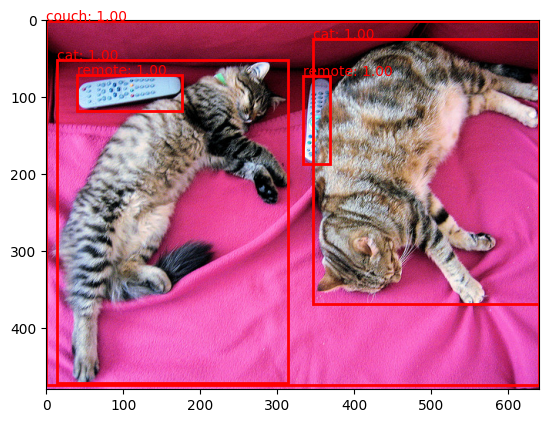

In [ ]:
import matplotlib.pyplot as plt
# display object detection results on image
onnxruntime_outputs = ort_session.run(None, onnxruntime_input)
plt.imshow(image)
for score, label, box in zip(onnxruntime_outputs[0], onnxruntime_outputs[1], onnxruntime_outputs[2]):
    plt.gca().add_patch(plt.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], fill=False, color="red", linewidth=2))
    label = model.config.id2label[label]
    plt.gca().text(box[0], box[1], f"{label}: {score:.2f}", color="red")
plt.show()

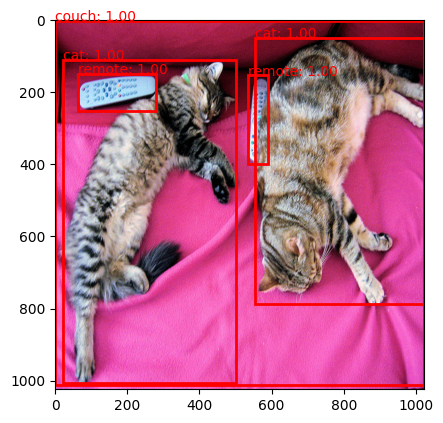

In [15]:
import matplotlib.pyplot as plt
# display object detection results on image
plt.imshow(image_big)
for score, label, box in zip(onnxruntime_outputs_big[0], onnxruntime_outputs_big[1], onnxruntime_outputs_big[2]):
    plt.gca().add_patch(plt.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], fill=False, color="red", linewidth=2))
    label = model.config.id2label[label]
    plt.gca().text(box[0], box[1], f"{label}: {score:.2f}", color="red")
plt.show()